In [1]:
import pandas as pd

train_df = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/train.csv")
test_df = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/test.csv")

train_df.shape, test_df.shape

((28800, 60), (3, 58))

In [2]:
train_df_set = set(train_df.columns)
test_df_set = set(test_df.columns)

test_missing_cols = train_df_set - test_df_set
test_extra_cols = test_df_set - train_df_set

print(f'Missing cols in test.csv: {test_missing_cols}')
print(f'Extra cols in test.csv: {test_extra_cols}')

Missing cols in test.csv: {'efs', 'efs_time'}
Extra cols in test.csv: set()


Only `efs` (target) and `efs_time` cols are missing in test.csv

# 1. EDA

In [3]:
efs_dist = train_df['efs'].value_counts(normalize=True)
efs_dist

efs
1.0    0.539306
0.0    0.460694
Name: proportion, dtype: float64

## Analyse efs distribution

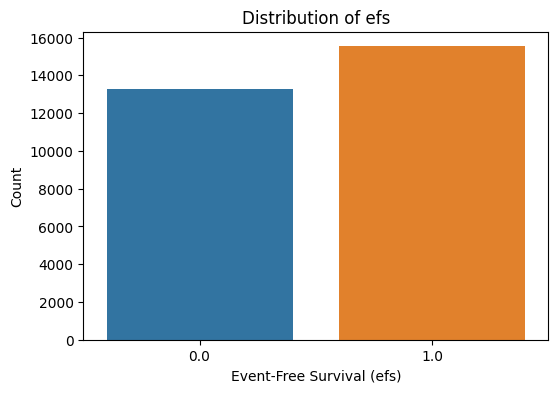

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# identify class imbalance
# the model might become biased toward predicting the dominant class

plt.figure(figsize=(6, 4))
sns.countplot(x='efs', data=train_df)
plt.title('Distribution of efs')
plt.xlabel('Event-Free Survival (efs)')
plt.ylabel('Count')
plt.show()

## Analyse efs_time

In [5]:
# efs_time: Time to event-free survival, months
efs_time = train_df['efs_time']
efs_time.describe()

count    28800.000000
mean        23.237678
std         24.799748
min          0.333000
25%          5.619750
50%          9.796500
75%         35.100000
max        156.819000
Name: efs_time, dtype: float64

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


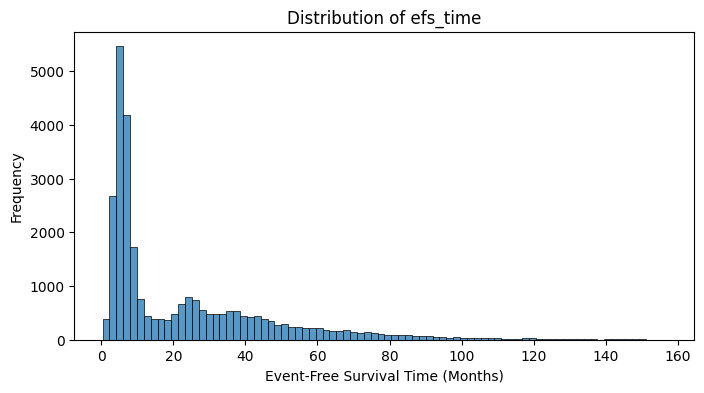

In [6]:
plt.figure(figsize=(8, 4))
sns.histplot(efs_time)
plt.title('Distribution of efs_time')
plt.xlabel('Event-Free Survival Time (Months)')
plt.ylabel('Frequency')
plt.show()

## Correlation between efs and efs_time

In [7]:
from scipy.stats import pointbiserialr

# efs: binary value
# efs_time: continuous 
# efs and efs_time: point-biserial correlation is used to measure their relationship
# relationship between a continuous variable (efs_time) and a dichotomous variable (efs)

corr_coef, p_value = pointbiserialr(train_df['efs'], train_df['efs_time'])
print(f'efs and efs_time corr coefficient: {corr_coef:.4f}')
print(f'statistically significant: {p_value:.4f}')

efs and efs_time corr coefficient: -0.7410
statistically significant: 0.0000


strong negative correlation -0.74 between `efs` and `efs_time`\
longer `efs_time` are associated with `efs 0`\
shorter `efs_time` are associated with `efs 1`\
`p-value 0.0` show very strong statistical significant between these two values\

`efs_time` is important feature of the model and is missing in `test`
- impute `efs_time` using regression model
- Train a regression model on the training data where `efs_time` is the target

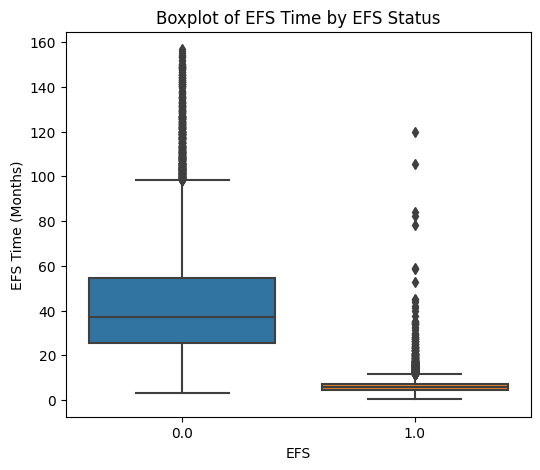

In [8]:
plt.figure(figsize=(6, 5))
sns.boxplot(x='efs', y='efs_time', data=train_df)
plt.title('Boxplot of EFS Time by EFS Status')
plt.xlabel('EFS')
plt.ylabel('EFS Time (Months)')
plt.show()

EFS = 1
- event-free for relatively short-time period
- some outliers with significantly longer efs-time


EFS = 0
- outliers indicates a longer survival time before event

## Missing Data Analysis

In [9]:
missing_data = train_df.isnull().mean() * 100
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)
missing_data.count()

50

In [10]:
missing_data_test = test_df.isnull().mean() * 100
missing_data_test = missing_data_test[missing_data_test > 0].sort_values(ascending=False)
missing_data_test.count()

11

In [11]:
# columns with high missingness > 40%
HIGH_MISSINGNESS_PERC = 40

high_missing_data = missing_data[missing_data > HIGH_MISSINGNESS_PERC].sort_values(ascending=False)
# decide later to impute or exclude
# all of these features with high missing values are categorical features
high_missing_data

tce_match            65.958333
mrd_hct              57.628472
cyto_score_detail    41.399306
dtype: float64

In [12]:
high_missing_data_test = missing_data_test[missing_data_test > HIGH_MISSINGNESS_PERC].sort_values(ascending=False)
# decide later to impute or exclude
# all of these features with high missing values are categorical features
high_missing_data_test

cyto_score                66.666667
cyto_score_detail         66.666667
conditioning_intensity    66.666667
mrd_hct                   66.666667
tce_match                 66.666667
donor_age                 66.666667
dtype: float64

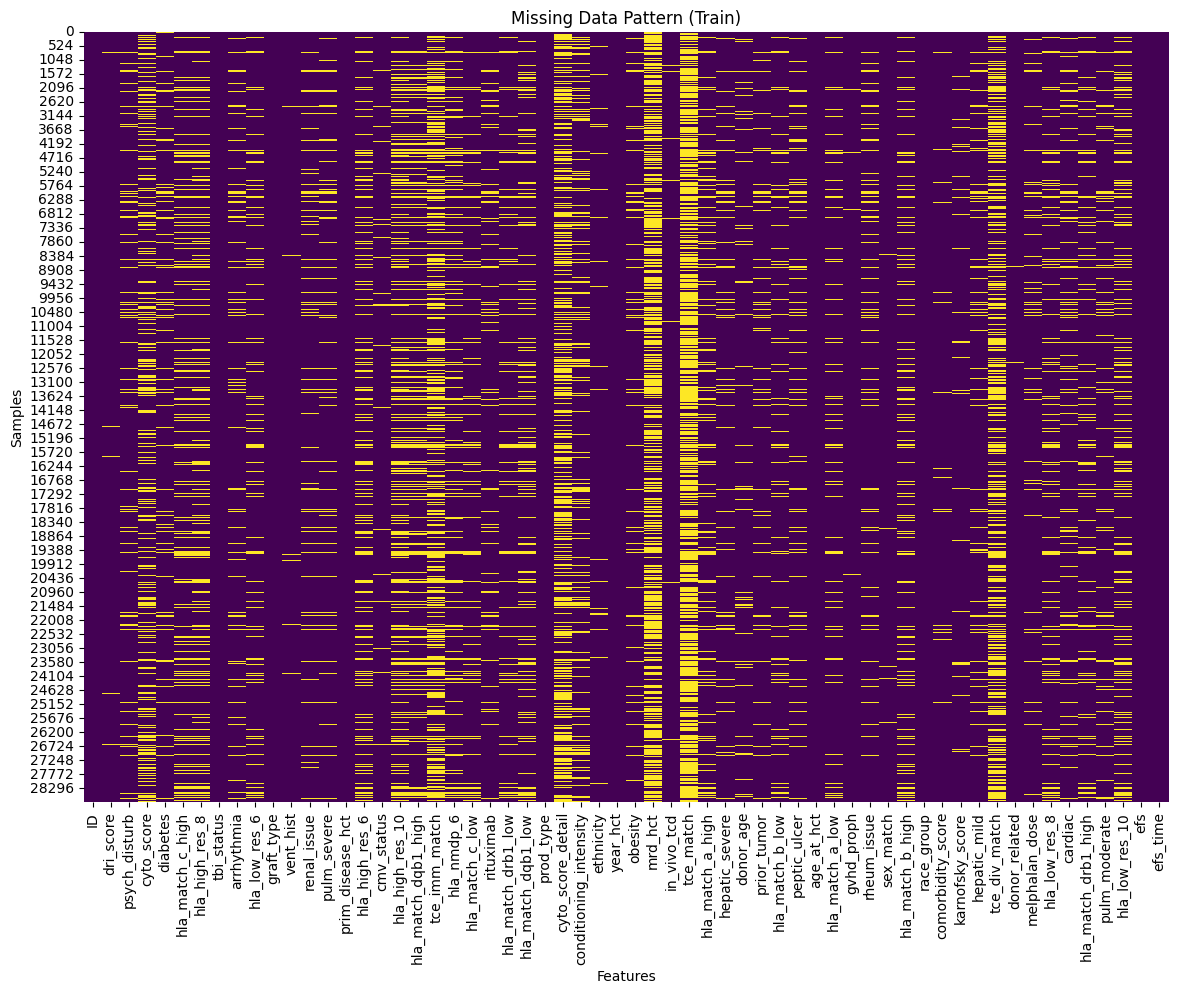

In [13]:
plt.figure(figsize=(14, 10))
sns.heatmap(train_df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Data Pattern (Train)")
plt.xlabel("Features")
plt.ylabel("Samples")
plt.show()

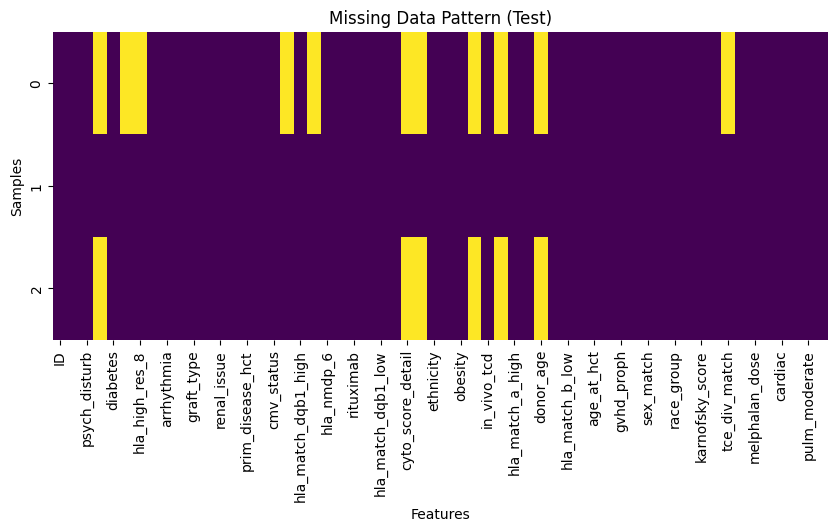

In [14]:
plt.figure(figsize=(10, 4))
sns.heatmap(test_df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Data Pattern (Test)")
plt.xlabel("Features")
plt.ylabel("Samples")
plt.show()

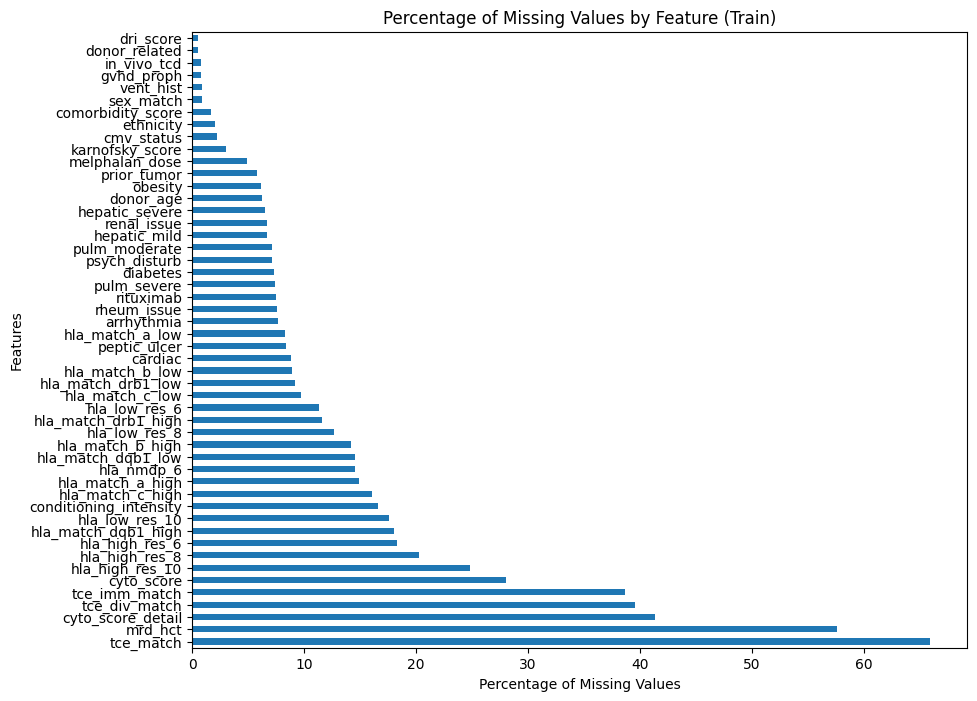

In [15]:
plt.figure(figsize=(10, 8))
missing_data.plot(kind='barh')
plt.title('Percentage of Missing Values by Feature (Train)')
plt.xlabel('Percentage of Missing Values')
plt.ylabel('Features')
plt.show()

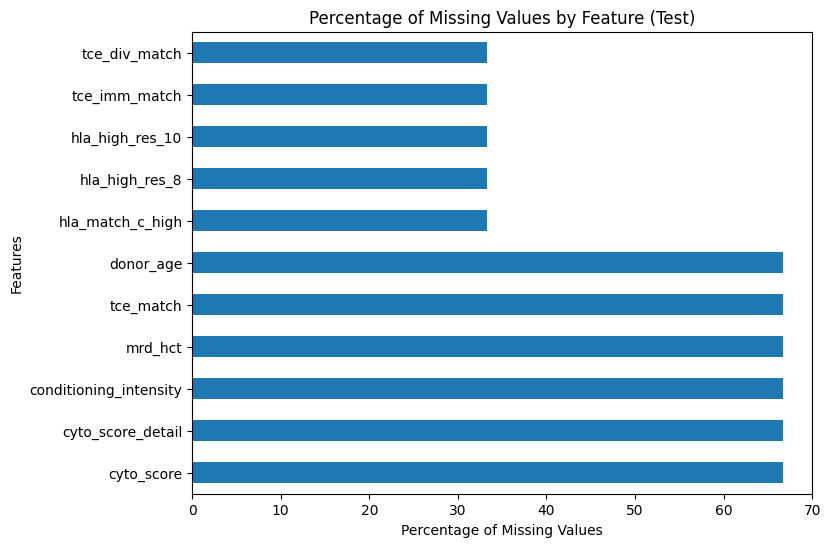

In [16]:
plt.figure(figsize=(8, 6))
missing_data_test.plot(kind='barh')
plt.title('Percentage of Missing Values by Feature (Test)')
plt.xlabel('Percentage of Missing Values')
plt.ylabel('Features')
plt.show()

## Numerical Feature Analysis

In [17]:
numerical_features = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_features.remove('ID')
numerical_features.remove('efs')
numerical_features.remove('efs_time')

print(f'Numerical features count: {len(numerical_features)}')

Numerical features count: 22


In [18]:
numerical_features_test = test_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_features_test.remove('ID')

print(f'Numerical features (Test) count: {len(numerical_features_test)}')

Numerical features (Test) count: 22


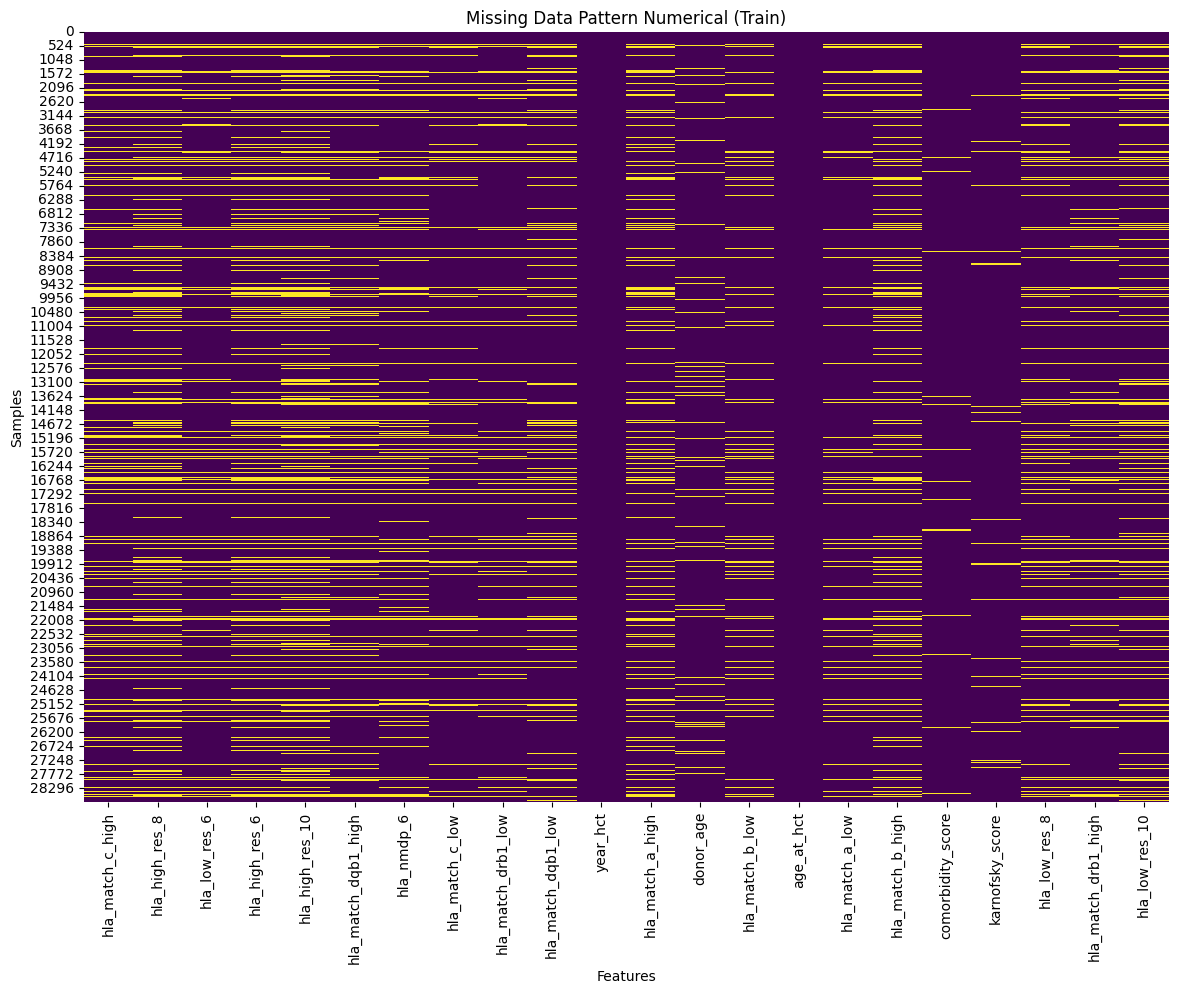

In [19]:
plt.figure(figsize=(14, 10))
sns.heatmap(train_df[numerical_features].isnull(), cbar=False, cmap='viridis')
plt.title("Missing Data Pattern Numerical (Train)")
plt.xlabel("Features")
plt.ylabel("Samples")
plt.show()

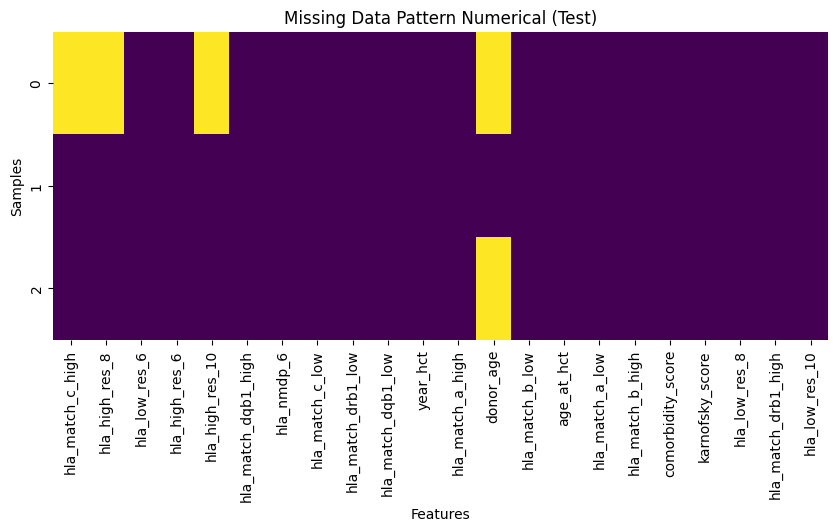

In [20]:
plt.figure(figsize=(10, 4))
sns.heatmap(test_df[numerical_features_test].isnull(), cbar=False, cmap='viridis')
plt.title("Missing Data Pattern Numerical (Test)")
plt.xlabel("Features")
plt.ylabel("Samples")
plt.show()

In [21]:
missing_data_numerical = train_df[numerical_features].isnull().mean() * 100
missing_data_numerical = missing_data_numerical[missing_data_numerical > 0].sort_values(ascending=False)

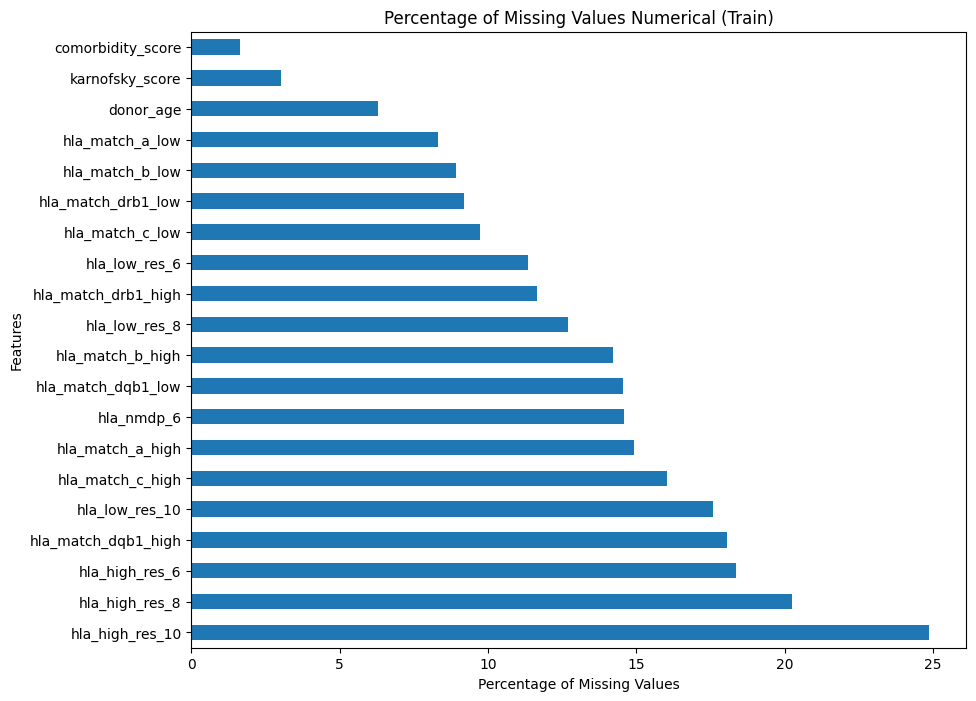

In [22]:
plt.figure(figsize=(10, 8))
missing_data_numerical.plot(kind='barh')
plt.title('Percentage of Missing Values Numerical (Train)')
plt.xlabel('Percentage of Missing Values')
plt.ylabel('Features')
plt.show()

In [23]:
missing_data_numerical_test = test_df[numerical_features_test].isnull().mean() * 100
missing_data_numerical_test = missing_data_numerical_test[missing_data_numerical_test > 0].sort_values(ascending=False)

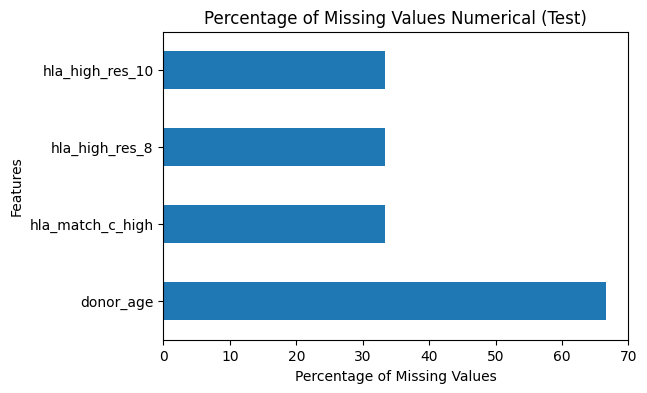

In [24]:
plt.figure(figsize=(6, 4))
missing_data_numerical_test.plot(kind='barh')
plt.title('Percentage of Missing Values Numerical (Test)')
plt.xlabel('Percentage of Missing Values')
plt.ylabel('Features')
plt.show()

In [25]:
numerical_summary_desc = train_df[numerical_features].describe().T
numerical_summary_desc

,count,mean,std,min,25%,50%,75%,max
hla_match_c_high,24180.0,1.764516,0.431941,0.000,2.000,2.000,2.00000,2.000
hla_high_res_8,22971.0,6.876801,1.564313,2.000,6.000,8.000,8.00000,8.000
hla_low_res_6,25530.0,5.143322,1.207757,2.000,4.000,6.000,6.00000,6.000
hla_high_res_6,23516.0,5.109202,1.214162,0.000,4.000,6.000,6.00000,6.000
hla_high_res_10,21637.0,8.617230,1.905125,3.000,7.000,10.000,10.00000,10.000
hla_match_dqb1_high,23601.0,1.736876,0.447687,0.000,1.000,2.000,2.00000,2.000
hla_nmdp_6,24603.0,5.160346,1.203240,2.000,4.000,6.000,6.00000,6.000
hla_match_c_low,26000.0,1.757808,0.435453,0.000,2.000,2.000,2.00000,2.000
hla_match_drb1_low,26157.0,1.715296,0.451282,1.000,1.000,2.000,2.00000,2.000
hla_match_dqb1_low,24606.0,1.773795,0.427130,0.000,2.000,2.000,2.00000,2.000


`age_at_hct`:        (0.04 - 73) years | medium 41 years\
`year_hct`:          (2008 - 20200)\
`donor_age`:         (18 - 84) years   | medium 40 years\
`comorbidity_score`: (0.00 - 10.00)    | medium: 2.00\
`karnofsky_score`:   (40.00 - 100.00)  | medium: 90.00



In [26]:
# 3 standard deviations from the mean
def has_outliers(series):
    mean, std = series.mean(), series.std()
    return ((series > mean + 3 * std) | (series < mean - 3 * std)).any()


numerical_summary = pd.DataFrame({
    'Feature': numerical_features,
    'Skewness': train_df[numerical_features].skew(),
    'Has Outliers': train_df[numerical_features].apply(has_outliers)
})

numerical_summary

,Feature,Skewness,Has Outliers
hla_match_c_high,hla_match_c_high,-1.367969,True
hla_high_res_8,hla_high_res_8,-0.972463,True
hla_low_res_6,hla_low_res_6,-0.949163,False
hla_high_res_6,hla_high_res_6,-0.892156,True
hla_high_res_10,hla_high_res_10,-0.998479,False
hla_match_dqb1_high,hla_match_dqb1_high,-1.184635,True
hla_nmdp_6,hla_nmdp_6,-1.014100,False
hla_match_c_low,hla_match_c_low,-1.313565,True
hla_match_drb1_low,hla_match_drb1_low,-0.954226,False
hla_match_dqb1_low,hla_match_dqb1_low,-1.450511,True


In [27]:
SKEW_THRESHOLD = 0.75


skewed_features = numerical_summary[numerical_summary['Skewness'].abs() > SKEW_THRESHOLD]['Feature'].tolist()

features_with_outliers = numerical_summary[numerical_summary['Has Outliers']]['Feature'].tolist()

normally_distributed_features = numerical_summary[
    (numerical_summary['Skewness'].abs() <= SKEW_THRESHOLD) & (~numerical_summary['Has Outliers'])
]['Feature'].tolist()

print("Skewed Features:", skewed_features)
print("Features with Outliers:", features_with_outliers)
print("Normally Distributed Features:", normally_distributed_features)

Skewed Features: ['hla_match_c_high', 'hla_high_res_8', 'hla_low_res_6', 'hla_high_res_6', 'hla_high_res_10', 'hla_match_dqb1_high', 'hla_nmdp_6', 'hla_match_c_low', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'year_hct', 'hla_match_a_high', 'hla_match_b_low', 'hla_match_a_low', 'hla_match_b_high', 'comorbidity_score', 'hla_low_res_8', 'hla_match_drb1_high', 'hla_low_res_10']
Features with Outliers: ['hla_match_c_high', 'hla_high_res_8', 'hla_high_res_6', 'hla_match_dqb1_high', 'hla_match_c_low', 'hla_match_dqb1_low', 'hla_match_a_high', 'hla_match_b_low', 'hla_match_a_low', 'hla_match_b_high', 'comorbidity_score', 'karnofsky_score', 'hla_low_res_8', 'hla_match_drb1_high']
Normally Distributed Features: ['donor_age', 'age_at_hct']



`Skewed Features`: hla_match_c_high, &ensp; hla_high_res_8, &ensp; hla_low_res_6, &ensp; hla_high_res_6, &ensp; hla_high_res_10, &ensp; hla_match_dqb1_high, &ensp; hla_nmdp_6, &ensp; hla_match_c_low, &ensp; hla_match_drb1_low, &ensp; hla_match_dqb1_low, &ensp; year_hct, &ensp; hla_match_a_high, &ensp; hla_match_b_low, &ensp; hla_match_a_low, &ensp; hla_match_b_high, &ensp; comorbidity_score, &ensp; hla_low_res_8, &ensp; hla_match_drb1_high, &ensp; hla_low_res_10\
\
`Features with Outliers`: hla_match_c_high, &ensp; hla_high_res_8, &ensp; hla_high_res_6, &ensp; hla_match_dqb1_high, &ensp; hla_match_c_low, &ensp; hla_match_dqb1_low, &ensp; hla_match_a_high, &ensp; hla_match_b_low, &ensp; hla_match_a_low, &ensp; hla_match_b_high, &ensp; comorbidity_score, &ensp; karnofsky_score, &ensp; hla_low_res_8, &ensp; hla_match_drb1_high\
\
`Normally Distributed Features`: donor_age, &ensp; age_at_hct

# Correlation with Target (Numerical)

In [28]:
numerical_corr_with_target = train_df[numerical_features].corrwith(train_df['efs']).sort_values(ascending=False)
numerical_corr_with_target

age_at_hct             0.227866
comorbidity_score      0.145723
hla_match_drb1_high    0.074446
hla_match_drb1_low     0.067485
hla_high_res_10        0.048431
donor_age              0.047566
hla_low_res_6          0.047007
hla_high_res_6         0.045261
hla_high_res_8         0.044224
hla_low_res_10         0.041972
hla_match_b_low        0.040965
hla_low_res_8          0.040612
hla_nmdp_6             0.040145
hla_match_dqb1_high    0.039736
hla_match_dqb1_low     0.032440
hla_match_c_high       0.031850
hla_match_b_high       0.026293
hla_match_c_low        0.016335
hla_match_a_high       0.015881
hla_match_a_low        0.015086
karnofsky_score       -0.091156
year_hct              -0.106419
dtype: float64

Highly positive --\
`age_at_hct`: older age has higher likelidhood of efs 1\
`comorbidity_score`: higher comorbidity_score tends to have higher efs\

Highly Negative --\
`karnofsky_score`: higher karnofsky_score tends to associate with lower efs (counterintuitive)\
`year_hct`: operations in recent years tends to have slightly lower efs (counterintuitive)

In [29]:
top_correlated_features = numerical_corr_with_target.head(6).index.tolist()
negatively_correlated_features = numerical_corr_with_target.tail(2).index.tolist()

selected_features = top_correlated_features + negatively_correlated_features
selected_features

['age_at_hct',
 'comorbidity_score',
 'hla_match_drb1_high',
 'hla_match_drb1_low',
 'hla_high_res_10',
 'donor_age',
 'karnofsky_score',
 'year_hct']

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


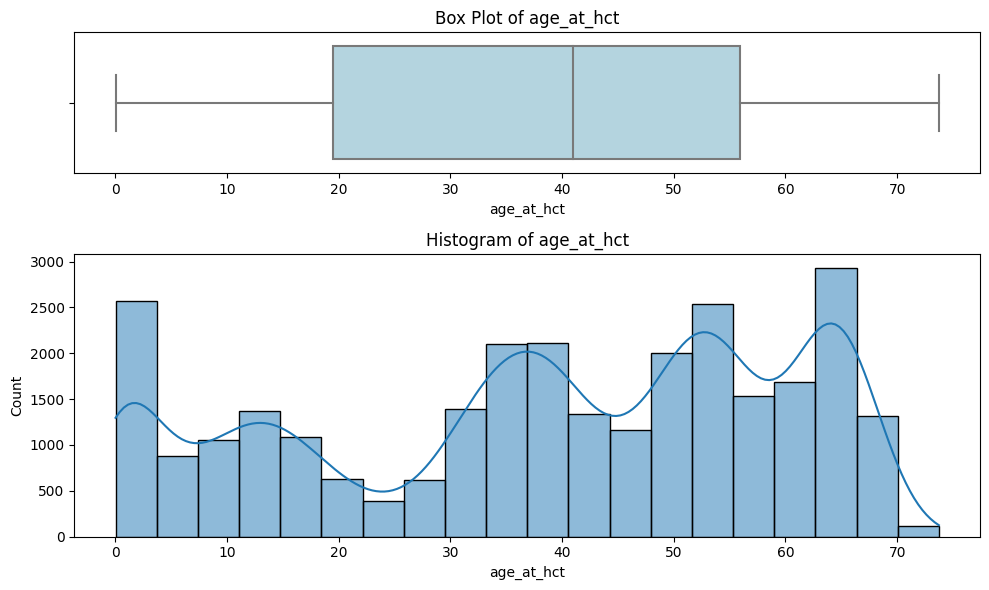

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


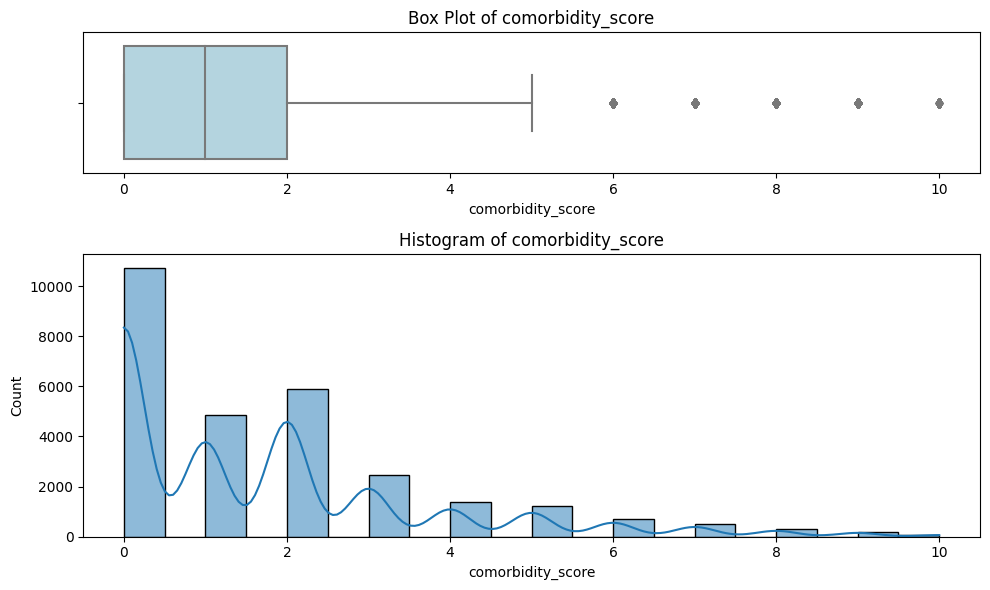

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


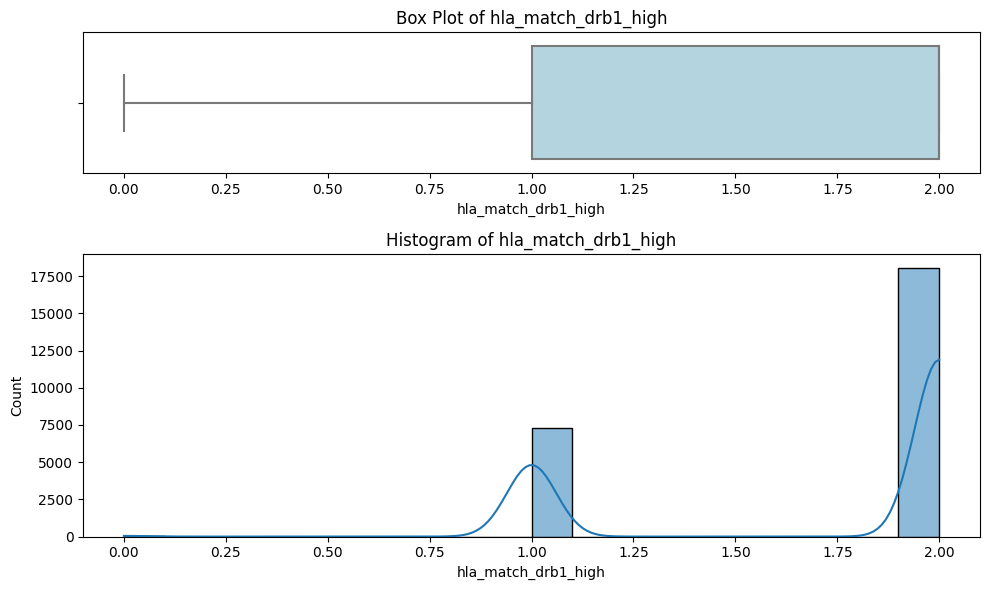

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


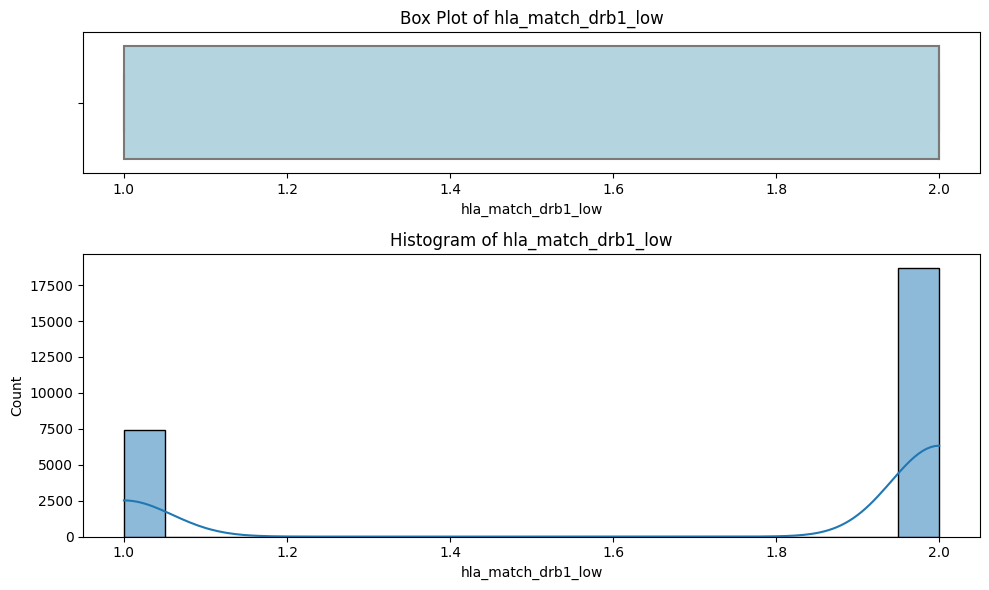

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


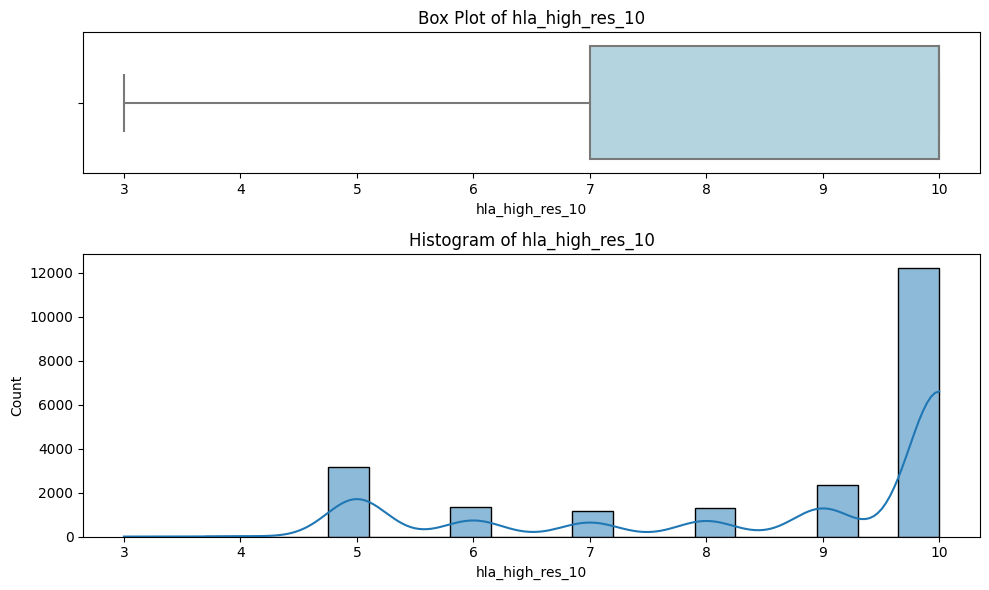

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


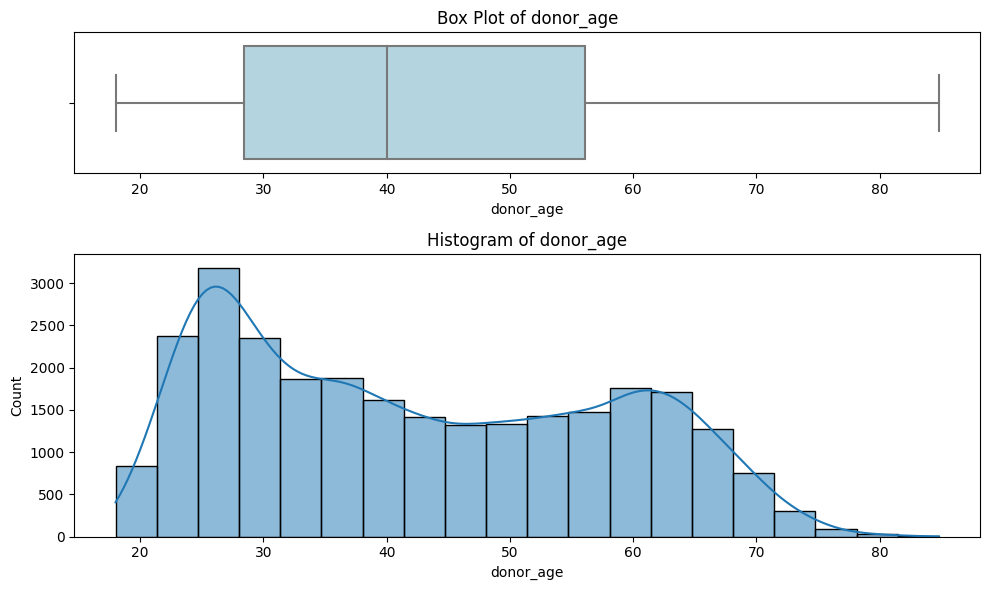

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


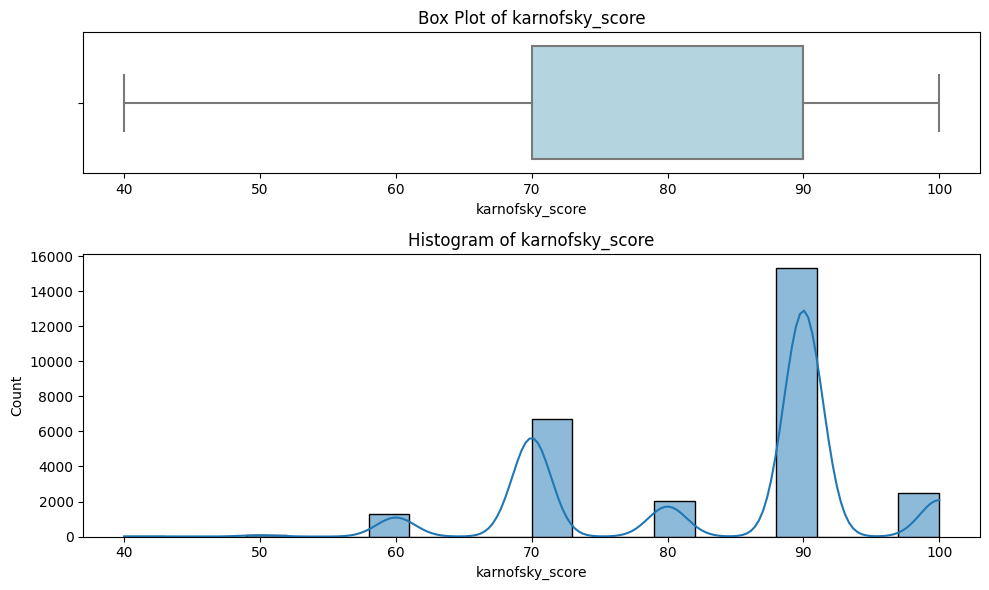

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


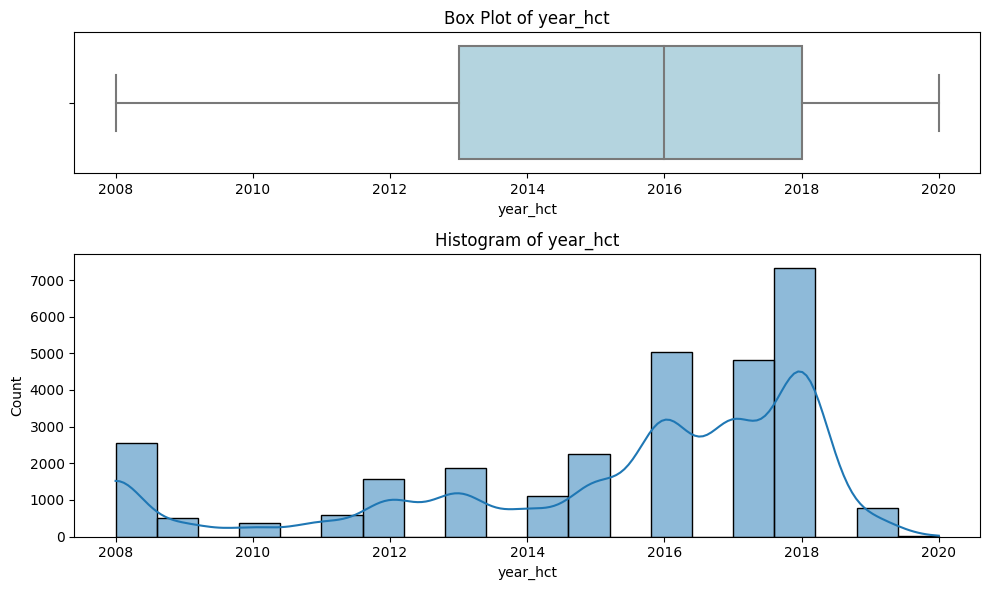

In [30]:
for feature in selected_features:
    fig, axes = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={"height_ratios": [1, 2]})
    sns.boxplot(x=train_df[feature], ax=axes[0], color='lightblue')
    axes[0].set_title(f'Box Plot of {feature}')
    sns.histplot(train_df[feature], bins=20, kde=True, ax=axes[1])
    axes[1].set_title(f'Histogram of {feature}')
    plt.tight_layout()
    plt.show()

`comorbidity_score` has outliers

## Categorical Feature Analysis

In [31]:
categorical_features = train_df.select_dtypes(include=['object']).columns.tolist()
print(f'Categorical features count: {len(categorical_features)}')

Categorical features count: 35


In [32]:
categorical_features_test = test_df.select_dtypes(include=['object']).columns.tolist()
print(f'Categorical features (Test) count: {len(categorical_features_test)}')

Categorical features (Test) count: 35


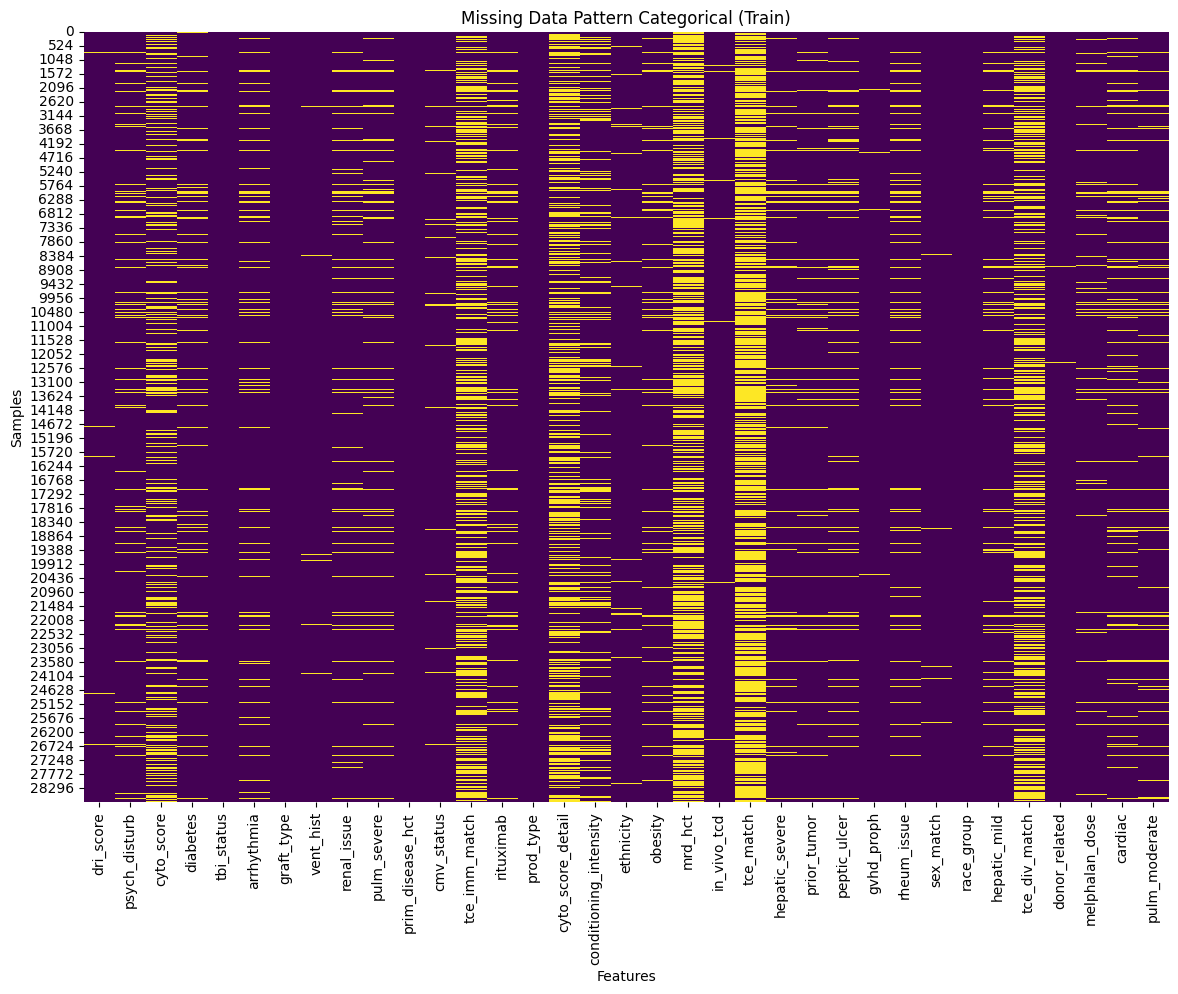

In [33]:
plt.figure(figsize=(14, 10))
sns.heatmap(train_df[categorical_features].isnull(), cbar=False, cmap='viridis')
plt.title("Missing Data Pattern Categorical (Train)")
plt.xlabel("Features")
plt.ylabel("Samples")
plt.show()

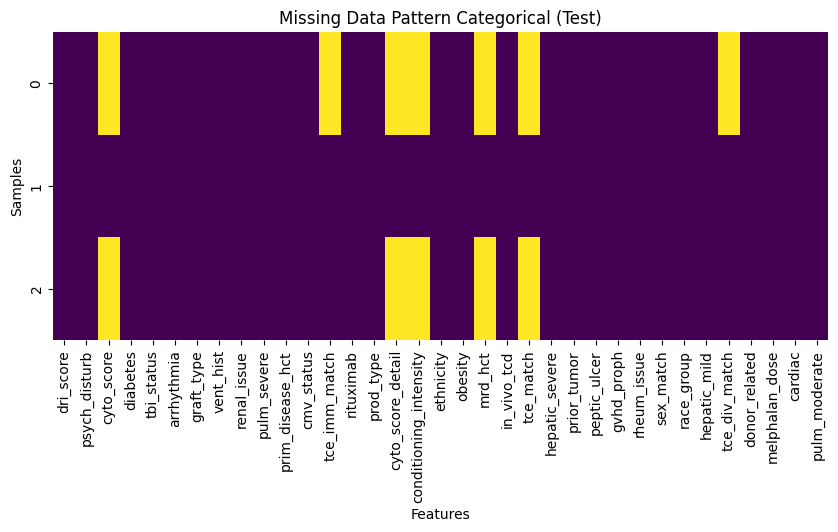

In [34]:
plt.figure(figsize=(10, 4))
sns.heatmap(test_df[categorical_features_test].isnull(), cbar=False, cmap='viridis')
plt.title("Missing Data Pattern Categorical (Test)")
plt.xlabel("Features")
plt.ylabel("Samples")
plt.show()

In [35]:
missing_data_categorical = train_df[categorical_features].isnull().mean() * 100
missing_data_categorical = missing_data_categorical[missing_data_categorical > 0].sort_values(ascending=False)

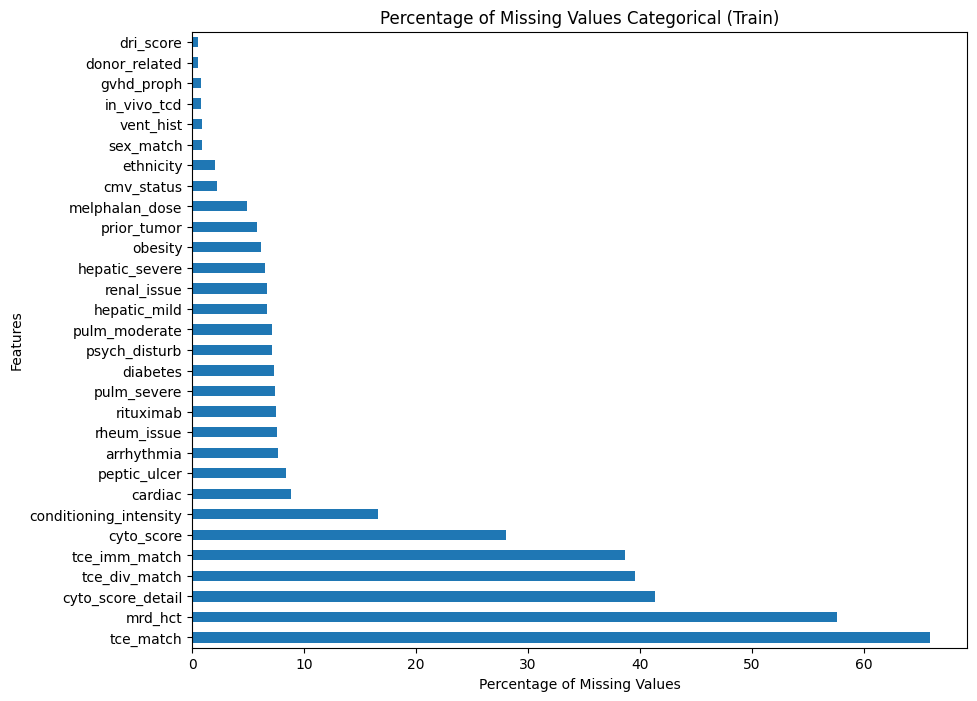

In [36]:
plt.figure(figsize=(10, 8))
missing_data_categorical.plot(kind='barh')
plt.title('Percentage of Missing Values Categorical (Train)')
plt.xlabel('Percentage of Missing Values')
plt.ylabel('Features')
plt.show()

In [37]:
missing_data_categorical_test = test_df[categorical_features_test].isnull().mean() * 100
missing_data_categorical_test = missing_data_categorical_test[missing_data_categorical_test > 0].sort_values(ascending=False)

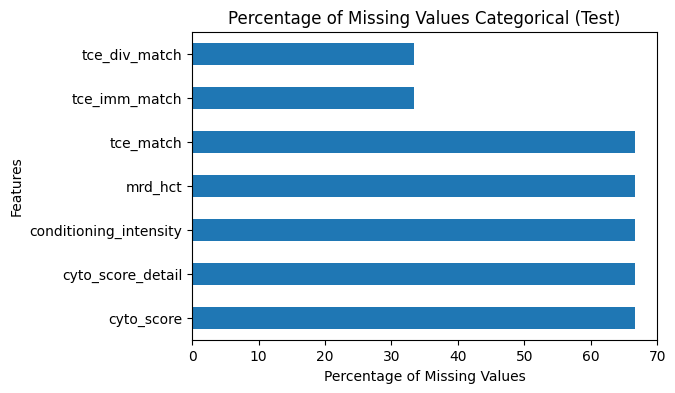

In [38]:
plt.figure(figsize=(6, 4))
missing_data_categorical_test.plot(kind='barh')
plt.title('Percentage of Missing Values Categorical (Test)')
plt.xlabel('Percentage of Missing Values')
plt.ylabel('Features')
plt.show()

## Identify Dominant and Rare category classes

In [39]:
import pandas as pd

# Thresholds
DOMINANT_THRESHOLD = 0.8 
RARE_THRESHOLD = 0.05

dominant_rare_info = {}

for feature in categorical_features:
    freq_counts = train_df[feature].value_counts(normalize=True)
    cumulative_percentage = freq_counts.cumsum()

    # Dominant categories
    dominant = freq_counts[cumulative_percentage <= DOMINANT_THRESHOLD].index.tolist()
    dominant_coverage = cumulative_percentage.loc[dominant[-1]] if dominant else 0.0

    # Rare categories
    rare = freq_counts[freq_counts < RARE_THRESHOLD].index.tolist()
    rare_coverage = freq_counts.loc[rare].sum() if rare else 0.0

    dominant_rare_info[feature] = {
        'total': len(freq_counts),
        'num_dominant': len(dominant),
        'num_rare': len(rare),
        'dominant_coverage': dominant_coverage * 100,
        'rare_coverage': rare_coverage * 100,
        'dominant_cats': dominant,
        'rare_cats': rare
    }

dominant_rare_df = pd.DataFrame(dominant_rare_info).T
dominant_rare_df

,total,num_dominant,num_rare,dominant_coverage,rare_coverage,dominant_cats,rare_cats
dri_score,11,4,5,77.996928,8.28737,"[Intermediate, N/A - pediatric, High, N/A - no...","[High - TED AML case <missing cytogenetics, In..."
psych_disturb,3,0,1,0.0,0.546039,[],[Not done]
cyto_score,7,2,3,73.210496,5.797801,"[Poor, Intermediate]","[Normal, Other, Not tested]"
diabetes,3,0,1,0.0,0.528466,[],[Not done]
tbi_status,8,1,4,65.489583,1.416667,[No TBI],"[TBI +- Other, -cGy, single, TBI +- Other, -cG..."
arrhythmia,3,0,2,0.0,5.244755,[],"[Yes, Not done]"
graft_type,2,1,0,71.340278,0.0,[Peripheral blood],[]
vent_hist,2,0,1,0.0,2.87306,[],[Yes]
renal_issue,3,0,2,0.0,1.253487,[],"[Yes, Not done]"
pulm_severe,3,0,1,0.0,0.675042,[],[Not done]


Features with `dominant categories` may need frequency encoding or target encoding for models like 
- XGBoost
- LightGBM
- CatBoost

`Rare categories` could be merged or treated separately to prevent overfitting

`High cardinal` categorical class should use `target encoding`\
`Label encoding` without considering order (good for tree-based models)\
`Ordinal encoding` with inherent order (good for regression models)

In [40]:
dominant_rare_info_test = {}

for feature in categorical_features_test:
    freq_counts = test_df[feature].value_counts(normalize=True)
    cumulative_percentage = freq_counts.cumsum()

    dominant = freq_counts[cumulative_percentage <= DOMINANT_THRESHOLD].index.tolist()
    dominant_coverage = cumulative_percentage.loc[dominant[-1]] if dominant else 0.0

    rare = freq_counts[freq_counts < RARE_THRESHOLD].index.tolist()
    rare_coverage = freq_counts.loc[rare].sum() if rare else 0.0

    dominant_rare_info_test[feature] = {
        'total': len(freq_counts),
        'num_dominant': len(dominant),
        'num_rare': len(rare),
        'dominant_coverage': dominant_coverage * 100,
        'rare_coverage': rare_coverage * 100,
        'dominant_cats': dominant,
        'rare_cats': rare
    }

dominant_rare_df_test = pd.DataFrame(dominant_rare_info_test).T
dominant_rare_df_test

,total,num_dominant,num_rare,dominant_coverage,rare_coverage,dominant_cats,rare_cats
dri_score,2,1,0,66.666667,0.0,[N/A - non-malignant indication],[]
psych_disturb,1,0,0,0.0,0.0,[],[]
cyto_score,1,0,0,0.0,0.0,[],[]
diabetes,1,0,0,0.0,0.0,[],[]
tbi_status,2,1,0,66.666667,0.0,[No TBI],[]
arrhythmia,1,0,0,0.0,0.0,[],[]
graft_type,2,1,0,66.666667,0.0,[Bone marrow],[]
vent_hist,1,0,0,0.0,0.0,[],[]
renal_issue,1,0,0,0.0,0.0,[],[]
pulm_severe,1,0,0,0.0,0.0,[],[]


## Correlation with Target (Categorical)

In [41]:
# for feature in categorical_features:
#     plt.figure(figsize=(10, 5))
#     sns.countplot(data=train_df, x=feature, hue='efs', order=train_df[feature].value_counts().index)
#     plt.title(f'Relationship Between {feature} and efs')
#     plt.xlabel(feature)
#     plt.ylabel('Count')
#     plt.xticks(rotation=45, ha='right')
#     plt.show()

# 2. Preprocessing

Handling missing values > `40%`

Train
```bash
tce_match            65.958333      categorical
mrd_hct              57.628472      categorical
cyto_score_detail    41.399306      categorical
```
\
Test
```bash
cyto_score                66.666667    categorical 
cyto_score_detail         66.666667    categorical
conditioning_intensity    66.666667    categorical
mrd_hct                   66.666667    categorical
tce_match                 66.666667    categorical
donor_age                 66.666667    numerical
```

## Importance test for high missing features (with target)

In [42]:
from scipy.stats import chi2_contingency

chi_square_results = {}

# Apply the Chi-Square test to the categorical columns with high missingness 
for feature in high_missing_data.index.to_list():
    if feature in train_df.columns:
        contingency_table = pd.crosstab(train_df[feature], train_df['efs'])
        chi2, p, _, _ = chi2_contingency(contingency_table)
        chi_square_results[feature] = {'Chi2': chi2, 'P-Value': p}

chi_square_df = pd.DataFrame(chi_square_results).T
chi_square_df.index.name = 'Feature'
chi_square_df.reset_index(inplace=True)

chi_square_df

,Feature,Chi2,P-Value
0,tce_match,26.525748,7.401409e-06
1,mrd_hct,8.845882,2.937509e-03
2,cyto_score_detail,187.095535,2.230346e-39


`Higher chi-square` indicates a `stronger` association between the feature and the target\
`A small p-value` (typically < 0.05) means the feature is `statistically significant`\
`A large p-value` suggests `no strong evidence` that the feature impact to target

\
`tce_match` (drop: risky for imputation -> high missing percentage)\
`mrd_hct` (drop: risky for imputation -> weaker association, high missing percentage)\
`cyto_score_detail` (keep for imputation)

In [43]:
# Features to drop due to high missing percentages
features_to_drop = ['tce_match', 'mrd_hct']

train_df_dropped = train_df.drop(columns=features_to_drop)
test_df_dropped = test_df.drop(columns=features_to_drop)

categorical_features_dropped = train_df_dropped.select_dtypes(include=['object']).columns.tolist()

## Imputation strategy

`Mode` imputation is used for `categorical`

In [44]:
train_df_dropped = train_df_dropped.fillna(train_df_dropped[categorical_features_dropped].mode().iloc[0])
test_df_dropped = test_df_dropped.fillna(test_df_dropped[categorical_features_dropped].mode().iloc[0])

`Mean` imputation for normally distributed `numerical` feats\
`Medium` imputation for skewed data with outliers `numerical` feats

In [45]:
median_imputed_cols = list(set(skewed_features + features_with_outliers))
mean_imputed_cols = normally_distributed_features

train_df_dropped = train_df_dropped.fillna(train_df_dropped[median_imputed_cols].median())
train_df_dropped = train_df_dropped.fillna(train_df_dropped[mean_imputed_cols].mean())
test_df_dropped = test_df_dropped.fillna(test_df_dropped[median_imputed_cols].median())
test_df_dropped = test_df_dropped.fillna(test_df_dropped[mean_imputed_cols].mean())

In [46]:
train_df_imputed = train_df_dropped.copy()
test_df_imputed = test_df_dropped.copy()

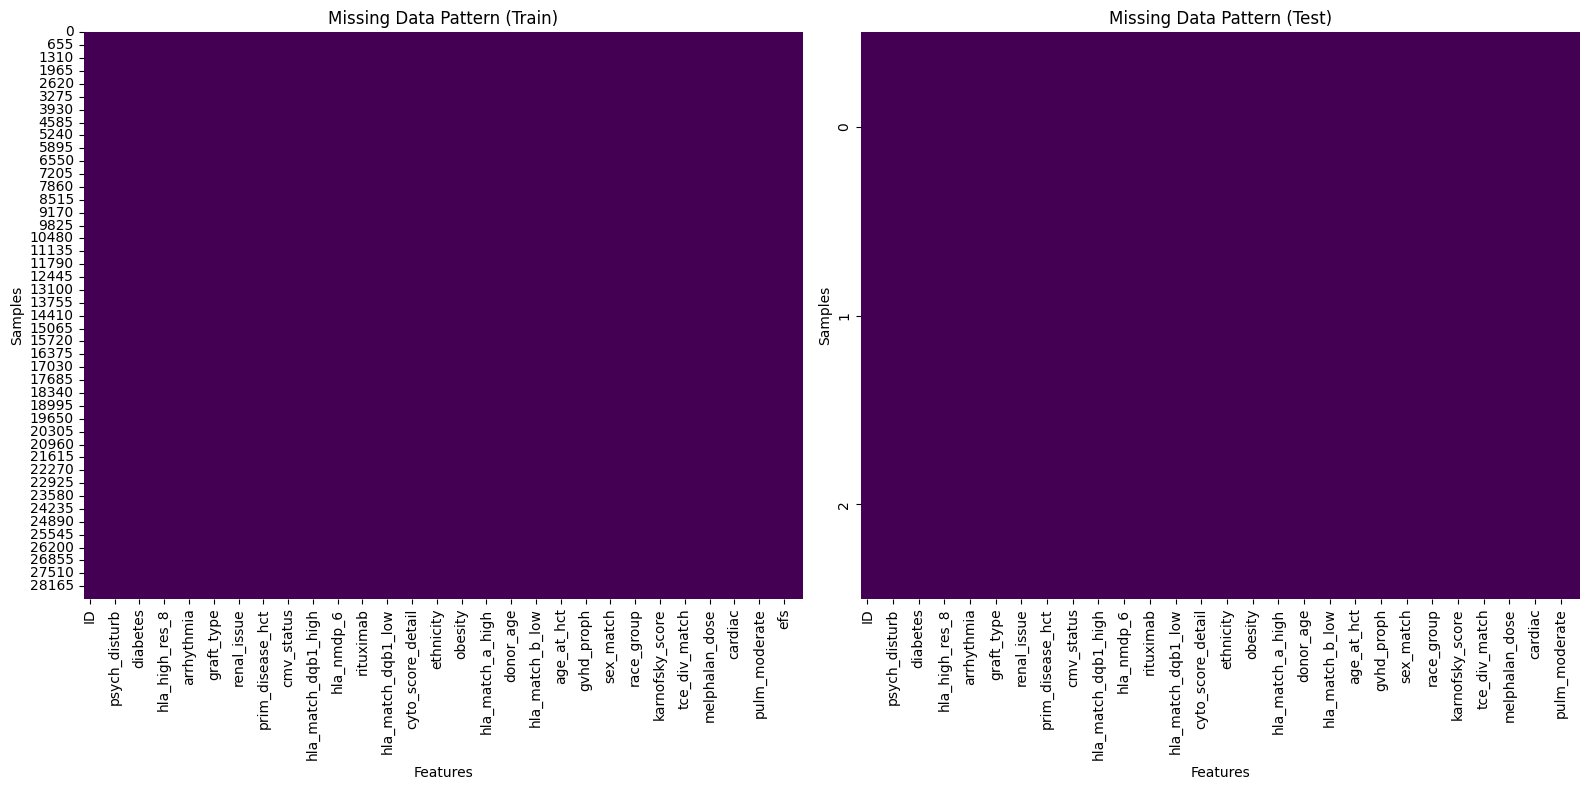

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

sns.heatmap(train_df_imputed.isnull(), cbar=False, cmap='viridis', ax=axes[0])
axes[0].set_title("Missing Data Pattern (Train)")
axes[0].set_xlabel("Features")
axes[0].set_ylabel("Samples")
sns.heatmap(test_df_imputed.isnull(), cbar=False, cmap='viridis', ax=axes[1])
axes[1].set_title("Missing Data Pattern (Test)")
axes[1].set_xlabel("Features")
axes[1].set_ylabel("Samples")
plt.tight_layout()
plt.show()

## Identify high and low cardinality features

In [48]:
HIGH_CARDINALITY_THRESHOLD = 7

unique_count = train_df_imputed[categorical_features_dropped].nunique()

high_cardinality_features = unique_count[unique_count > HIGH_CARDINALITY_THRESHOLD].index.tolist()
low_cardinality_features = unique_count[unique_count <= HIGH_CARDINALITY_THRESHOLD].index.tolist()

print(f'High Cardinality Features: {high_cardinality_features}')
print(f'Low Cardinality Features: {low_cardinality_features}')

High Cardinality Features: ['dri_score', 'tbi_status', 'prim_disease_hct', 'tce_imm_match', 'gvhd_proph']
Low Cardinality Features: ['psych_disturb', 'cyto_score', 'diabetes', 'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'cmv_status', 'rituximab', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'obesity', 'in_vivo_tcd', 'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'rheum_issue', 'sex_match', 'race_group', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'cardiac', 'pulm_moderate']


## Encoding cateogrical features

In [49]:
train_df_preprocessed = train_df_imputed.copy()
test_df_preprocessed = test_df_imputed.copy()

`Target Encoding` for `high-cardinality features`.

Target encoding replaces each category with the mean of the target variable


In [50]:
!pip install category-encoders

In [51]:
# from category_encoders import TargetEncoder

# target_encoder = TargetEncoder()

# train_df_preprocessed[high_cardinality_features] = target_encoder.fit_transform(
#     train_df_imputed[high_cardinality_features], train_df_imputed['efs']
# )

# test_df_preprocessed[high_cardinality_features] = target_encoder.transform(
#     test_df_imputed[high_cardinality_features]
# )

`Ordinal encoding` for `low cardanility features`\
\
Ordinal encoding when there is a natural order among categories

In [52]:
# from sklearn.preprocessing import OrdinalEncoder

# ordinal_features_order = {
#     'cyto_score': ['Poor', 'Intermediate', 'Favorable'],
#     'cyto_score_detail': ['Poor', 'Intermediate', 'Favorable', 'TBD', 'Not tested'],
#     'conditioning_intensity': ['NMA', 'RIC', 'MAC', 'TBD', 'No drugs reported', 'N/A, F(pre-TED) not submitted'],
#     'pulm_severe': ['No', 'Yes', 'Not done'],
#     'hepatic_severe': ['No', 'Yes', 'Not done'],
#     'renal_issue': ['No', 'Yes', 'Not done'],
#     'obesity': ['No', 'Yes', 'Not done'],
#     'pulm_moderate': ['No', 'Yes', 'Not done'],
#     'hepatic_mild': ['No', 'Yes', 'Not done'],
# }

# for feature, order in ordinal_features_order.items():
#     encoder = OrdinalEncoder(categories=[order], handle_unknown='use_encoded_value', unknown_value=-1)
#     train_df_preprocessed[feature + '_ordinal'] = encoder.fit_transform(train_df_dropped[[feature]])
#     test_df_preprocessed[feature + '_ordinal'] = encoder.transform(test_df_dropped[[feature]])

`Label encoding` is applied to features without a natural order.

In [53]:
from sklearn.preprocessing import LabelEncoder


# label_features = list(set(low_cardinality_features) - set(ordinal_features_order.keys()))
for feature in categorical_features_dropped:
    encoder = LabelEncoder()
    train_df_preprocessed[feature] = encoder.fit_transform(train_df_dropped[feature].astype(str))
    test_df_preprocessed[feature] = encoder.transform(test_df_dropped[feature].astype(str))

In [54]:
# train_df_preprocessed = train_df_preprocessed.drop(columns=low_cardinality_features)
# test_df_preprocessed = test_df_preprocessed.drop(columns=low_cardinality_features)

## Validation Train and Test data columns match

In [55]:
train_df_preprocessed_set = set(train_df_preprocessed.columns)
test_df_preprocessed_set = set(test_df_preprocessed.columns)

test_missing_cols = train_df_preprocessed_set - test_df_preprocessed_set
test_extra_cols = test_df_preprocessed_set - train_df_preprocessed_set

print(f'Missing cols in test.csv: {test_missing_cols}')
print(f'Extra cols in test.csv: {test_extra_cols}')

print(f'Train preprocessed dataset shape: {train_df_preprocessed.shape}')
print(f'Test preprocessed dataset shape: {test_df_preprocessed.shape}')

Missing cols in test.csv: {'efs', 'efs_time'}
Extra cols in test.csv: set()
Train preprocessed dataset shape: (28800, 58)
Test preprocessed dataset shape: (3, 56)


## Impute `efs_time` using regression model

`efs_time` is missing in the `test` dataset\
Use the training dataset where `efs_time` is already available

In [56]:
from sklearn.model_selection import train_test_split

X_preprocessed = train_df_preprocessed.drop(columns=['efs', 'efs_time'])
y_preprocessed =train_df_preprocessed['efs_time']

X_pp_train, X_pp_test, y_pp_train, y_pp_test = train_test_split(
    X_preprocessed, y_preprocessed, test_size=0.2, random_state=42
)

will use `Random forest` to predict efs_time for test dataset

In [57]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(random_state=42, n_estimators=100)
regressor.fit(X_pp_train, y_pp_train)

RandomForestRegressor(random_state=42)

`evaluate` the model

In [58]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_pp_predict = regressor.predict(X_pp_test)

mae = mean_absolute_error(y_pp_test, y_pp_predict)
mse = mean_squared_error(y_pp_test, y_pp_predict)
rmse = np.sqrt(mse)
r2 = r2_score(y_pp_test, y_pp_predict)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Absolute Error (MAE): 17.6410
Mean Squared Error (MSE): 528.4146
Root Mean Squared Error (RMSE): 22.9873
R² Score: 0.1521


Predict `efs_time` for the test dataset

In [59]:
X_preprocessed_test = test_df_preprocessed.copy()
predicted_efs_time = regressor.predict(X_preprocessed_test)
predicted_efs_time

array([19.75077, 31.39766, 14.70448])

In [60]:
test_df_preprocessed['efs_time'] = predicted_efs_time
test_df_preprocessed.head()

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,...,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs_time
0,28800,7,0,1,0,2.0,8.0,0,0,6.0,...,0,3,2,1,8.0,0,2.0,0,10.0,19.75077
1,28801,2,0,1,0,2.0,8.0,6,0,6.0,...,0,3,1,1,8.0,0,2.0,2,10.0,31.39766
2,28802,7,0,1,0,2.0,8.0,0,0,6.0,...,0,3,1,1,8.0,0,2.0,0,10.0,14.70448


In [61]:
# train_df_preprocessed.to_csv('data/train_preprocessed.csv', index=True)
# test_df_preprocessed.to_csv('data/test_preprocessed.csv', index=True)

# 3. Cross-Validation for Models

Data preparation

In [62]:
X = train_df_preprocessed.drop(columns=['ID', 'efs'])
y = train_df_preprocessed['efs']

X_test = test_df_preprocessed.drop(columns=['ID'])

# Ensure the columns in X_test are in the same order as in X
X_test = X_test[X.columns]

print(f'X dataset shape: {X.shape}')
print(f'X_test dataset shape: {X_test.shape}')

X dataset shape: (28800, 56)
X_test dataset shape: (3, 56)


In [63]:
X_test_missing_cols = set(X.columns) - set(X_test.columns)
X_test_extra_cols = set(X_test.columns) - set(X.columns)

print(f'Missing cols in test.csv: {X_test_missing_cols}')
print(f'Extra cols in test.csv: {X_test_extra_cols}')

Missing cols in test.csv: set()
Extra cols in test.csv: set()


`cross-validation` to ensure each fold maintains same proportion of classes (0 and 1)\
`5-fold cross-validation` will be used for evaluating the models

In [64]:
from sklearn.model_selection import StratifiedKFold

# Create stratified K-fold object
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

Models\
\
`Logistic Regression`\
`Decision Tree`\
`Random Forest`\
`XGBoost`\
`LightGBM`\
`CatBoost`

In [65]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

# Define models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=5000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'XGBoost': xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': lgb.LGBMClassifier(random_state=42),
}

### Evaluation metrics

`ROC-AUC`: Measures the model's ability to distinguish between classes.\
`Precision`: Measures how many of the positive predictions were actually correct.\
`Recall`: Measures how many of the actual positive cases were correctly identified.\
`F1-Score`: Harmonic mean of precision and recall, balancing both metrics.

In [66]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, make_scorer

scoring_metrics = {
    'roc_auc': make_scorer(roc_auc_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

`cross-validation` to evaluate each model on all four metrics

In [67]:
!pip install xgboost

In [68]:
from sklearn.model_selection import cross_validate

# Evaluate each model using cross-validation
results = {}
for name, model in models.items():
    scores = cross_validate(model, X, y, cv=skf, scoring=scoring_metrics)

    roc_auc = scores['test_roc_auc'].mean()
    precision = scores['test_precision'].mean()
    recall = scores['test_recall'].mean()
    f1 = scores['test_f1'].mean()

    results[name] = {
        'ROC-AUC': roc_auc,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

results_df = pd.DataFrame(results).T
print("Baseline Model Performance:")
print(results_df)


[LightGBM] [Info] Number of positive: 12426, number of negative: 10614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1030
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539323 -> initscore=0.157617
[LightGBM] [Info] Start training from score 0.157617
[LightGBM] [Info] Number of positive: 12426, number of negative: 10614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007754 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1030
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 56
[LightGBM] [Info] [b

First attempt

| Model                | ROC-AUC | Precision | Recall  | F1 Score |
|----------------------|---------|-----------|---------|----------|
| Logistic Regression  | 0.9957  | 0.9723    | 0.9858  | 0.9790   |
| Decision Tree        | 0.9785  | 0.9794    | 0.9811  | 0.9803   |
| Random Forest        | 0.9967  | 0.9839    | 0.9856  | 0.9848   |
| XGBoost              | 0.9988  | 0.9897    | 0.9895  | 0.9896   |
| LightGBM             | 0.9988  | 0.9892    | 0.9891  | 0.9892   |

`XGBoost` performs best\
`LightGBM` second

# 4. Model Selection

fit the models

In [69]:
fitted_models = {}
for name, model in models.items():
    model.fit(X, y)
    fitted_models[name] = model

[LightGBM] [Info] Number of positive: 15532, number of negative: 13268
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008977 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1030
[LightGBM] [Info] Number of data points in the train set: 28800, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539306 -> initscore=0.157547
[LightGBM] [Info] Start training from score 0.157547


In [70]:
best_model = fitted_models['XGBoost']

In [71]:
assert test_df_preprocessed['ID'].min() == 28800, "ID column should start from 28800"

In [72]:
assert list(X.columns) == list(X_test.columns), "Feature order mismatch!"

In [73]:
test_risk_scores = best_model.predict_proba(X_test)[:, 1]
submission = pd.DataFrame({
    'ID': test_df_preprocessed['ID'],
    'prediction': test_risk_scores
})

# Save the submission file in CSV format
submission_file_path = 'submission.csv'
submission.to_csv(submission_file_path, index=False)

In [74]:
test_risk_scores

array([0.0009982 , 0.01023597, 0.00026787], dtype=float32)

In [75]:
print('DONE!')

DONE!
